# Notebook 02: Multi-Car Race Simulation

**Extending the physics model to simulate full race grids with dirty air effects and pit stops**

---

## Objectives

1. Implement a `RaceSimulator` class for multi-car races
2. Model dirty air (aerodynamic wake) effects on following cars
3. Handle pit stop logic with compound changes
4. Track race positions based on cumulative time
5. Simulate the full Hungary 2023 grid

---

## New Physics: Dirty Air

### Wake Turbulence Effect

When a car follows another closely, it loses downforce due to disturbed airflow:

$$\text{Penalty} = \frac{\text{MaxPenalty}}{1 + (\text{Gap} / \text{RefGap})^2}$$

**Parameters:**
- `max_penalty` = 1.2s (at zero gap)
- `ref_gap` = 0.8s (gap where penalty halves)
- Penalty decays with inverse-square law

**Track Sensitivity:**
- High downforce tracks (Hungary, Monaco): Higher sensitivity
- Low downforce tracks (Monza, Spa): Lower sensitivity

### Why This Matters

Dirty air explains why:
- Overtaking is difficult in F1
- Track position has intrinsic value
- Undercuts work (fresh tyres in clean air)

---

## Notebook Dependencies

- `numpy`, `pandas`, `matplotlib`, `seaborn`
- `dataclasses` — Cleaner class definitions
- Classes from Notebook 01 (conceptually, redefined here for modularity)

In [ ]:
"""
Multi-Car Race Simulation
Building on 01_Tyre_Degradation_Physics Car class with dirty air effects
"""


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass, field
from typing import List, Dict, Optional


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")





---

## Car Dataclass

Updated `Car` using `@dataclass` for cleaner attribute management:
- Driver and team identification
- Base pace and degradation parameters
- Tire state tracking (age, compound, stint)
- Pit stop schedule

In [ ]:
@dataclass
class Car:
    """
    Represents a single F1 car in the simulation.

    """


    driver: str
    team: str


    base_pace: float
    Tyre_deg_rate: float = 0.035
    fuel_effect: float = 0.035


    Tyre_age: int = 0
    fuel_load: float = 110.0
    current_lap: int = 0
    total_time: float = 0.0
    position: int = 0


    pit_laps: List[int] = field(default_factory=list)
    compounds: List[str] = field(default_factory=lambda: ["MEDIUM"])
    current_stint: int = 1
    current_compound: str = "MEDIUM"

    def reset(self):
        """Reset car state for new simulation."""
        self.Tyre_age = 0
        self.fuel_load = 110.0
        self.current_lap = 0
        self.total_time = 0.0
        self.position = 0
        self.current_stint = 1
        if self.compounds:
            self.current_compound = self.compounds[0]


test_car = Car(driver="PIA", team="McLaren", base_pace=82.3)
print(f"Car class created successfully")
print(f"Test car: {test_car.driver} ({test_car.team})")
print(f"Base pace: {test_car.base_pace}s")

Car class created successfully
Test car: PIA (McLaren)
Base pace: 82.3s


---

## Dirty Air Penalty Model

Physics-based model for aerodynamic wake effects:
- Uses inverse-square decay (realistic wake dissipation)
- Track sensitivity multiplier for circuit characteristics
- Returns 0 for leader (clean air) or large gaps (>10s)

In [ ]:
def calculate_dirty_air_penalty(
    gap_ahead: float,
    max_penalty: float = 1.2,
    reference_gap: float = 0.8,
    track_sensitivity: float = 1.0
) -> float:
    """
    Calculating lap time penalty from following another car in dirty air.

    Parameters:
    -----------
    gap_ahead : float
        Time gap to car ahead in seconds.
        None or negative = no car ahead (clean air).

    max_penalty : float, default=1.2
        Maximum penalty at zero gap (seconds).
        Based on real F1 data: ~1.0-1.5s loss when directly behind.

    reference_gap : float, default=0.8
        Gap at which penalty halves (seconds).
        Calibrated to match empirical dirty air range (~1-1.5s significant effect).

    track_sensitivity : float, default=1.0
        Multiplier for track-specific downforce dependency.
        Hungary (high downforce): 1.0-1.2
        Monza (low downforce): 0.6-0.8

    Returns:
    --------
    float
        Lap time penalty in seconds (always >= 0)

    Physics:
    - Wake turbulence reduces downforce on following car
    - Less downforce = less grip = slower cornering
    - Effect decays with distance as wake dissipates
    """

    # No car ahead or leading the race = clean air
    if gap_ahead is None or gap_ahead < 0:
        return 0.0

    # Very large gaps = essentially clean air
    if gap_ahead > 10.0:
        return 0.0

    # Core formula: inverse-square decay
    # At gap=0: penalty = max_penalty
    # At gap=reference_gap: penalty = max_penalty / 2
    # As gap→∞: penalty → 0
    penalty = max_penalty / (1.0 + (gap_ahead / reference_gap) ** 2)

    # Apply track sensitivity
    penalty *= track_sensitivity

    return penalty




print("DIRTY AIR MODEL VERIFICATION")


test_gaps = [0.0, 0.3, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0]

print(f"\n{'Gap (s)':<10} {'Penalty (s)':<12} {'% of Max':<10}")
print("-" * 35)

for gap in test_gaps:
    penalty = calculate_dirty_air_penalty(gap)
    pct = (penalty / 1.2) * 100  # 1.2 is default max_penalty
    print(f"{gap:<10.1f} {penalty:<12.3f} {pct:<10.1f}%")




DIRTY AIR MODEL VERIFICATION

Gap (s)    Penalty (s)  % of Max  
-----------------------------------
0.0        1.200        100.0     %
0.3        1.052        87.7      %
0.5        0.863        71.9      %
0.8        0.600        50.0      %
1.0        0.468        39.0      %
1.5        0.266        22.1      %
2.0        0.166        13.8      %
3.0        0.080        6.6       %
5.0        0.030        2.5       %


---

## Dirty Air Visualization

Plotting the penalty curve shows:
1. Severe penalty at very close gaps (<0.5s)
2. Significant effect up to ~2s gap
3. Clean air effectively restored beyond 3-4s
4. Track-specific variations (Hungary vs Monza)

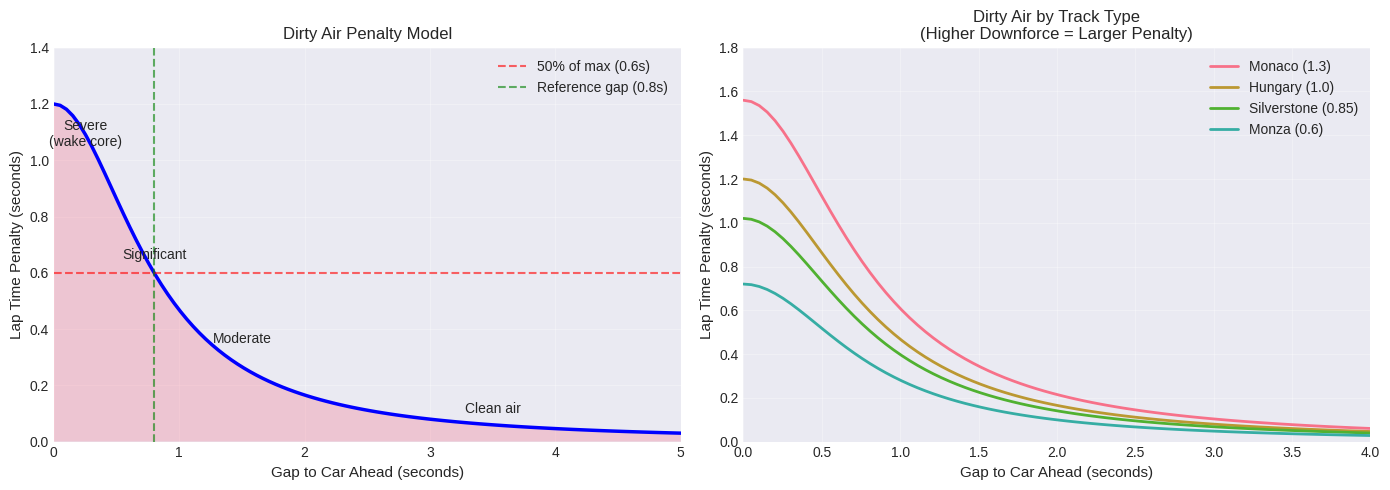

In [ ]:
# Visualize the dirty air penalty curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Penalty vs Gap
ax1 = axes[0]
gaps = np.linspace(0, 5, 100)
penalties = [calculate_dirty_air_penalty(g) for g in gaps]

ax1.plot(gaps, penalties, 'b-', linewidth=2.5)
ax1.fill_between(gaps, penalties, alpha=0.3)

# Reference lines
ax1.axhline(y=0.6, color='r', linestyle='--', alpha=0.6, label='50% of max (0.6s)')
ax1.axvline(x=0.8, color='g', linestyle='--', alpha=0.6, label='Reference gap (0.8s)')

# Annotations
ax1.annotate('Severe\n(wake core)', xy=(0.25, 1.05), fontsize=10, ha='center')
ax1.annotate('Significant', xy=(0.8, 0.65), fontsize=10, ha='center')
ax1.annotate('Moderate', xy=(1.5, 0.35), fontsize=10, ha='center')
ax1.annotate('Clean air', xy=(3.5, 0.1), fontsize=10, ha='center')

ax1.set_xlabel('Gap to Car Ahead (seconds)', fontsize=11)
ax1.set_ylabel('Lap Time Penalty (seconds)', fontsize=11)
ax1.set_title('Dirty Air Penalty Model', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 1.4)

# Plot 2: Track Comparison
ax2 = axes[1]

track_configs = {
    'Monaco (1.3)': 1.3,      # Tight, high downforce
    'Hungary (1.0)': 1.0,     # High downforce baseline
    'Silverstone (0.85)': 0.85,  # Medium-high
    'Monza (0.6)': 0.6        # Low downforce, lap done mostly in straights
}

for track_name, sensitivity in track_configs.items():
    penalties = [calculate_dirty_air_penalty(g, track_sensitivity=sensitivity) for g in gaps]
    ax2.plot(gaps, penalties, linewidth=2, label=track_name)

ax2.set_xlabel('Gap to Car Ahead (seconds)', fontsize=11)
ax2.set_ylabel('Lap Time Penalty (seconds)', fontsize=11)
ax2.set_title('Dirty Air by Track Type\n(Higher Downforce = Larger Penalty)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 4)
ax2.set_ylim(0, 1.8)

plt.tight_layout()
plt.show()

---

## RaceSimulator Class

The main simulation engine that:
1. Manages all cars and their states
2. Calculates inter-car gaps each lap
3. Applies dirty air penalties based on gaps
4. Handles pit stop timing and compound changes
5. Records lap-by-lap history for analysis

**Key methods:**
- `get_cars_by_position()` — Sort by cumulative time
- `calculate_gaps()` — Time to car ahead
- `calculate_lap_time()` — Full physics model
- `handle_pit_stop()` — Execute stop, reset tires
- `simulate_lap()` — One lap for all cars
- `run_race()` — Complete race simulation

In [ ]:
class RaceSimulator:
    """
    Simulate a full F1 race with multiple cars, dirty air, and pit stops.

    This class orchestrates the Tyre simulation:
    - Manages all cars and their states
    - Calculates inter-car gaps for dirty air
    - Handles pit stop logic
    - Records lap-by-lap history

    Attributes:
    -----------
    cars : List[Car]
        All cars in the race
    total_laps : int
        Race distance (70 for Hungary)
    pit_stop_loss : float
        Time lost per pit stop (seconds)
    track_sensitivity : float
        Dirty air multiplier for this track
    history : List[dict]
        Lap-by-lap record for post-race analysis
    """

    def __init__(
        self,
        cars: List[Car],
        total_laps: int = 70,
        pit_stop_loss: float = 22.0,
        track_sensitivity: float = 1.0
    ):
        """
        Initialize the race simulator.

        Parameters:
        -----------
        cars : List[Car]
            Cars to race. Order = starting grid (index 0 = pole).
        total_laps : int
            Race distance in laps.
        pit_stop_loss : float
            Time lost per pit stop (pit lane + stationary).
            Hungary typical: 22-25 seconds.
        track_sensitivity : float
            Dirty air multiplier.
            Hungary = 1.0 (high downforce, baseline)
        """
        self.cars = cars
        self.total_laps = total_laps
        self.pit_stop_loss = pit_stop_loss
        self.track_sensitivity = track_sensitivity

        # Set starting grid positions
        for i, car in enumerate(self.cars):
            car.position = i + 1  # 1-indexed (P1, P2, ...)
            car.reset()           # Clean state for new race

        # History storage
        self.history: List[Dict] = []
        self.current_lap = 0

    def get_cars_by_position(self) -> List[Car]:
        """
        Return cars sorted by race position (P1 first).

        Position = lowest cumulative time = leading.

        Returns:
        --------
        List[Car] sorted by total_time ascending
        """
        return sorted(self.cars, key=lambda c: c.total_time)

    def calculate_gaps(self) -> Dict[str, Optional[float]]:
        """
        Calculate time gap to car directly ahead for each car.

        Returns:
        --------
        Dict mapping driver code to gap (seconds).
        Leader has gap = None.

        Example:
        {'VER': None, 'HAM': 1.5, 'PIA': 0.8}
        VER leading, HAM 1.5s behind VER, PIA 0.8s behind HAM.
        """
        sorted_cars = self.get_cars_by_position()
        gaps = {}

        for i, car in enumerate(sorted_cars):
            if i == 0:

                gaps[car.driver] = None
            else:
                # Gap to car directly ahead
                car_ahead = sorted_cars[i - 1]
                gap = car.total_time - car_ahead.total_time
                gaps[car.driver] = gap

        return gaps



# Create test cars replace with full grid later
test_cars = [
    Car(driver="HAM", team="Mercedes", base_pace=82.5),
    Car(driver="VER", team="Red Bull", base_pace=82.3),
    Car(driver="PIA", team="McLaren", base_pace=82.3),
]

test_sim = RaceSimulator(cars=test_cars, total_laps=70)

print(f"  Cars: {len(test_sim.cars)}")
print(f"  Total laps: {test_sim.total_laps}")
print(f"  Pit stop loss: {test_sim.pit_stop_loss}s")

Simulator created successfully
  Cars: 3
  Total laps: 70
  Pit stop loss: 22.0s


In [ ]:
# Add methods to the RaceSimulator class

class RaceSimulator:
    """
    Full RaceSimulator with lap time calculation.
    """

    def __init__(
        self,
        cars: List[Car],
        total_laps: int = 70,
        pit_stop_loss: float = 22.0,
        track_sensitivity: float = 1.0
    ):
        self.cars = cars
        self.total_laps = total_laps
        self.pit_stop_loss = pit_stop_loss
        self.track_sensitivity = track_sensitivity

        for i, car in enumerate(self.cars):
            car.position = i + 1
            car.reset()

        self.history: List[Dict] = []
        self.current_lap = 0

    def get_cars_by_position(self) -> List[Car]:
        """Return cars sorted by total_time (P1 first)."""
        return sorted(self.cars, key=lambda c: c.total_time)

    def calculate_gaps(self) -> Dict[str, Optional[float]]:
        """Calculate gap to car ahead for each car."""
        sorted_cars = self.get_cars_by_position()
        gaps = {}

        for i, car in enumerate(sorted_cars):
            if i == 0:
                gaps[car.driver] = None
            else:
                car_ahead = sorted_cars[i - 1]
                gaps[car.driver] = car.total_time - car_ahead.total_time

        return gaps

    def calculate_lap_time(self, car: Car, gap_ahead: Optional[float]) -> float:
        """
        Calculate lap time for a single car.

        Components:
        1. Base pace — car + driver potential
        2. Tyre degradation — grip loss with wear
        3. Fuel effect — lighter = faster
        4. Dirty air — penalty for following

        Parameters:
        -----------
        car : Car
            The car to calculate for
        gap_ahead : Optional[float]
            Gap to car ahead (None if leading)

        Returns:
        --------
        float : Lap time in seconds
        """

        #BASE PACE

        lap_time = car.base_pace

        Tyre_penalty = car.Tyre_age * car.Tyre_deg_rate
        lap_time += Tyre_penalty




        #FUEL EFFECT
        fuel_benefit = car.current_lap * car.fuel_effect
        lap_time -= fuel_benefit


        dirty_air_penalty = calculate_dirty_air_penalty(
            gap_ahead=gap_ahead,
            track_sensitivity=self.track_sensitivity
        )
        lap_time += dirty_air_penalty

        return lap_time

    def handle_pit_stop(self, car: Car) -> float:
        """
        Process a pit stop.

        Effects:
        - Reset Tyre age to 0
        - Move to next stint
        - Switch to next compound

        Returns:

        float : Pit stop time loss
        """
        car.Tyre_age = 0
        car.current_stint += 1

        # Switch compound
        if car.current_stint <= len(car.compounds):
            car.current_compound = car.compounds[car.current_stint - 1]

        return self.pit_stop_loss


# Test lap time calculation
test_cars = [
    Car(driver="VER", team="Red Bull", base_pace=82.3),
    Car(driver="PIA", team="McLaren", base_pace=82.3),
]

sim = RaceSimulator(cars=test_cars, total_laps=70)

# Simulate a few laps manually for testing
print("\nManual lap simulation test:")
print(f"{'Lap':<5} {'Driver':<6} {'Tyre Age':<10} {'Gap Ahead':<12} {'Lap Time':<10}")
print("-" * 50)

for lap in range(1, 6):
    gaps = sim.calculate_gaps()

    for car in sim.cars:
        car.current_lap = lap
        car.Tyre_age += 1
        gap = gaps.get(car.driver)
        lap_time = sim.calculate_lap_time(car, gap)
        car.total_time += lap_time

        gap_str = f"{gap:.2f}s" if gap else "Leader"
        print(f"{lap:<5} {car.driver:<6} {car.Tyre_age:<10} {gap_str:<12} {lap_time:<10.3f}")

    # Update positions
    for i, car in enumerate(sim.get_cars_by_position()):
        car.position = i + 1



Manual lap simulation test:
Lap   Driver Tyre Age   Gap Ahead    Lap Time  
--------------------------------------------------
1     VER    1          Leader       82.300    
1     PIA    1          Leader       83.500    
2     VER    2          Leader       82.300    
2     PIA    2          1.20s        82.669    
3     VER    3          Leader       82.300    
3     PIA    3          1.57s        82.548    
4     VER    4          Leader       82.300    
4     PIA    4          1.82s        82.495    
5     VER    5          Leader       82.300    
5     PIA    5          2.01s        82.464    


In [ ]:
class RaceSimulator:
    """
    Complete RaceSimulator with all methods.
    Simulates full F1 race with dirty air, pit stops, position tracking.
    """

    def __init__(
        self,
        cars: List[Car],
        total_laps: int = 70,
        pit_stop_loss: float = 24.0,
        track_sensitivity: float = 1.0
    ):
        self.cars = cars
        self.total_laps = total_laps
        self.pit_stop_loss = pit_stop_loss
        self.track_sensitivity = track_sensitivity

        for i, car in enumerate(self.cars):
            car.position = i + 1
            car.reset()

        self.history: List[Dict] = []
        self.current_lap = 0

    def get_cars_by_position(self) -> List[Car]:
        """Return cars sorted by total_time (P1 first)."""
        return sorted(self.cars, key=lambda c: c.total_time)

    def calculate_gaps(self) -> Dict[str, Optional[float]]:
        """Calculate gap to car ahead for each car."""
        sorted_cars = self.get_cars_by_position()
        gaps = {}

        for i, car in enumerate(sorted_cars):
            if i == 0:
                gaps[car.driver] = None
            else:
                car_ahead = sorted_cars[i - 1]
                gaps[car.driver] = car.total_time - car_ahead.total_time

        return gaps

    def calculate_lap_time(self, car: Car, gap_ahead: Optional[float]) -> float:
        """
        Calculate lap time with all physics components.

        Components:
        1. Base pace
        2. Tyre degradation
        3. Fuel effect
        4. Dirty air
        """
        lap_time = car.base_pace

        # Tyre degradation: older Tyres = slower
        Tyre_penalty = car.Tyre_age * car.Tyre_deg_rate
        lap_time += Tyre_penalty

        # Fuel effect: lighter car = faster
        fuel_benefit = car.current_lap * car.fuel_effect
        lap_time -= fuel_benefit

        # Dirty air: following costs time
        dirty_air_penalty = calculate_dirty_air_penalty(
            gap_ahead=gap_ahead,
            track_sensitivity=self.track_sensitivity
        )
        lap_time += dirty_air_penalty

        return lap_time

    def handle_pit_stop(self, car: Car) -> float:
        """Process pit stop: reset Tyres, switch compound."""
        car.Tyre_age = 0
        car.current_stint += 1

        if car.current_stint <= len(car.compounds):
            car.current_compound = car.compounds[car.current_stint - 1]

        return self.pit_stop_loss

    def simulate_lap(self, lap_number: int) -> Dict:
        """
        Simulate one lap for all cars.

        Process:
        1. Get current gaps (before this lap)
        2. For each car:
           - Check for pit stop
           - Calculate lap time
           - Update state (Tyre age, total time)
        3. Update positions based on new total times
        4. Record snapshot to history

        Parameters:
        -----------
        lap_number : int
            Current lap (1 to total_laps)

        Returns:
        --------
        Dict : Snapshot of all car states after this lap
        """
        self.current_lap = lap_number

        # Get gaps BEFORE this lap's times are added
        gaps = self.calculate_gaps()

        # Store lap data
        lap_snapshot = {'lap': lap_number, 'cars': {}}

        # Process each car
        for car in self.cars:
            car.current_lap = lap_number

            # Check for pit stop
            is_pitting = lap_number in car.pit_laps

            if is_pitting:
                # Pit stop lap
                pit_loss = self.handle_pit_stop(car)
                gap_ahead = gaps.get(car.driver)
                base_lap_time = self.calculate_lap_time(car, gap_ahead)
                lap_time = base_lap_time + pit_loss
            else:
                # Normal racing lap
                car.Tyre_age += 1
                gap_ahead = gaps.get(car.driver)
                lap_time = self.calculate_lap_time(car, gap_ahead)

            # Update cumulative time
            car.total_time += lap_time

            # Record this car's lap data
            lap_snapshot['cars'][car.driver] = {
                'lap_time': lap_time,
                'total_time': car.total_time,
                'Tyre_age': car.Tyre_age,
                'compound': car.current_compound,
                'stint': car.current_stint,
                'gap_ahead': gap_ahead,
                'dirty_air_penalty': calculate_dirty_air_penalty(
                    gap_ahead, track_sensitivity=self.track_sensitivity
                ) if gap_ahead else 0,
                'is_pitting': is_pitting
            }

        # Update positions based on new total times
        sorted_cars = self.get_cars_by_position()
        for i, car in enumerate(sorted_cars):
            car.position = i + 1
            lap_snapshot['cars'][car.driver]['position'] = car.position

        # Store in history
        self.history.append(lap_snapshot)

        return lap_snapshot

    def run_race(self, verbose: bool = True) -> pd.DataFrame:
        """
        Execute the complete race simulation.

        Parameters:
        -----------
        verbose : bool
            If True, print progress updates

        Returns:
        --------
        pd.DataFrame : Complete lap-by-lap race data
        """
        if verbose:
            print(f"\n{'='*60}")
            print(f"RACE START: {self.total_laps} laps, {len(self.cars)} cars")
            print(f"{'='*60}")

        # Reset all cars for clean start
        for car in self.cars:
            car.reset()

        # Clear any previous history
        self.history = []

        # Simulate each lap
        for lap in range(1, self.total_laps + 1):
            self.simulate_lap(lap)

            # Progress updates
            if verbose and (lap % 10 == 0 or lap == self.total_laps):
                leader = self.get_cars_by_position()[0]
                print(f"  Lap {lap:2d}/{self.total_laps}: "
                      f"Leader = {leader.driver} ({leader.total_time:.1f}s)")

        if verbose:

           print("RACE COMPLETE")


        # Convert history to DataFrame
        return self._history_to_dataframe()

    def _history_to_dataframe(self) -> pd.DataFrame:

        rows = []
        for lap_data in self.history:
            lap = lap_data['lap']
            for driver, car_data in lap_data['cars'].items():
                row = {'lap': lap, 'driver': driver}
                row.update(car_data)
                rows.append(row)

        return pd.DataFrame(rows)

    def get_final_classification(self) -> pd.DataFrame:
        """
        Get final race standings.

        Returns:
        --------
        pd.DataFrame : Final positions with gaps to winner
        """
        sorted_cars = self.get_cars_by_position()
        winner_time = sorted_cars[0].total_time

        classification = []
        for car in sorted_cars:
            gap = car.total_time - winner_time
            classification.append({
                'Position': car.position,
                'Driver': car.driver,
                'Team': car.team,
                'Total Time (s)': round(car.total_time, 3),
                'Gap': f"+{gap:.3f}s" if gap > 0 else "WINNER",
                'Pit Stops': len(car.pit_laps)
            })

        return pd.DataFrame(classification)

---

## Hungary 2023 Grid Setup

Configuring all 20 cars with:
- Realistic base paces (calibrated to qualifying)
- Actual pit stop laps from the race
- Compound sequences as used
- Starting positions from the grid

**Focus drivers:**
- HAM (P1 start, pole)
- VER (P2)
- NOR (P3)
- PIA (P4 → jumped to P2 at start)

In [ ]:
TOTAL_LAPS = 70
PIT_STOP_LOSS = 22.0  # Hungaroring average pit loss ~22 seconds




hungary_2023_grid = [

    Car(
        driver="HAM",
        team="Mercedes",
        base_pace=82.65,
        pit_laps=[16, 43],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="VER",
        team="Red Bull",
        base_pace=82.30,
        pit_laps=[21, 46],
        compounds=["MEDIUM", "HARD", "HARD"]
    ),

    Car(
        driver="NOR",
        team="McLaren",
        base_pace=82.45,
        pit_laps=[17, 44],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="PIA",
        team="McLaren",
        base_pace=82.50,
        pit_laps=[18, 42],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),

    Car(
        driver="ZHO",
        team="Alfa Romeo",
        base_pace=83.50,
        pit_laps=[20, 45],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="LEC",
        team="Ferrari",
        base_pace=82.90,
        pit_laps=[21, 45],
        compounds=["MEDIUM", "HARD", "HARD"]
    ),


    Car(
        driver="BOT",
        team="Alfa Romeo",
        base_pace=83.40,
        pit_laps=[19, 44],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="ALO",
        team="Aston Martin",
        base_pace=83.10,
        pit_laps=[20, 45],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="PER",
        team="Red Bull",
        base_pace=82.70,
        pit_laps=[20, 44],
        compounds=["HARD", "MEDIUM", "MEDIUM"]
    ),


    Car(
        driver="HUL",
        team="Haas",
        base_pace=83.60,
        pit_laps=[19, 44],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="SAI",
        team="Ferrari",
        base_pace=82.95,
        pit_laps=[15, 40],
        compounds=["SOFT", "HARD", "HARD"]
    ),


    Car(
        driver="RIC",
        team="AlphaTauri",
        base_pace=84.00,
        pit_laps=[30],
        compounds=["MEDIUM", "HARD"]
    ),


    Car(
        driver="STR",
        team="Aston Martin",
        base_pace=83.30,
        pit_laps=[14, 39],
        compounds=["SOFT", "HARD", "HARD"]
    ),


    Car(
        driver="ALB",
        team="Williams",
        base_pace=84.20,
        pit_laps=[32],
        compounds=["MEDIUM", "HARD"]
    ),


    Car(
        driver="TSU",
        team="AlphaTauri",
        base_pace=84.10,
        pit_laps=[16, 42],
        compounds=["SOFT", "HARD", "MEDIUM"]
    ),


    Car(
        driver="RUS",
        team="Mercedes",
        base_pace=82.60,
        pit_laps=[18, 44],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),


    Car(
        driver="MAG",
        team="Haas",
        base_pace=83.70,
        pit_laps=[20, 45],
        compounds=["MEDIUM", "HARD", "MEDIUM"]
    ),

]


print(f"Grid configured with {len(hungary_2023_grid)} cars")
print(f"(Note: OCO, GAS, SAR excluded — DNF Lap 1 or mechanical)")
print()
print(f"{'Grid':<5} {'Driver':<6} {'Team':<15} {'Base Pace':<11} {'Pit Laps':<15} {'Strategy'}")
print("-" * 75)

for i, car in enumerate(hungary_2023_grid):
    pit_str = ", ".join(map(str, car.pit_laps))
    compound_str = "→".join([c[0] for c in car.compounds])  # M→H→M format
    print(f"P{i+1:<4} {car.driver:<6} {car.team:<15} {car.base_pace:<11.2f} [{pit_str:<12}] {compound_str}")


Grid configured with 17 cars
(Note: OCO, GAS, SAR excluded — DNF Lap 1 or mechanical)

Grid  Driver Team            Base Pace   Pit Laps        Strategy
---------------------------------------------------------------------------
P1    HAM    Mercedes        82.65       [16, 43      ] M→H→M
P2    VER    Red Bull        82.30       [21, 46      ] M→H→H
P3    NOR    McLaren         82.45       [17, 44      ] M→H→M
P4    PIA    McLaren         82.50       [18, 42      ] M→H→M
P5    ZHO    Alfa Romeo      83.50       [20, 45      ] M→H→M
P6    LEC    Ferrari         82.90       [21, 45      ] M→H→H
P7    BOT    Alfa Romeo      83.40       [19, 44      ] M→H→M
P8    ALO    Aston Martin    83.10       [20, 45      ] M→H→M
P9    PER    Red Bull        82.70       [20, 44      ] H→M→M
P10   HUL    Haas            83.60       [19, 44      ] M→H→M
P11   SAI    Ferrari         82.95       [15, 40      ] S→H→H
P12   RIC    AlphaTauri      84.00       [30          ] M→H
P13   STR    Aston Martin    

---

## Race Simulation

Running the full 70-lap Hungary simulation with:
- 22s pit stop time loss
- Track sensitivity = 1.0 (high downforce baseline)
- Verbose output showing key events

In [ ]:
# Create simulator with Hungary settings
simulator = RaceSimulator(
    cars=hungary_2023_grid,
    total_laps=70,
    pit_stop_loss=22.0,
    track_sensitivity=1.0
)


race_data = simulator.run_race(verbose=True)



print("FINAL CLASSIFICATION")


final_results = simulator.get_final_classification()
print(final_results.to_string(index=False))


RACE START: 70 laps, 17 cars
  Lap 10/70: Leader = HAM (826.5s)
  Lap 20/70: Leader = VER (1652.8s)
  Lap 30/70: Leader = VER (2490.5s)
  Lap 40/70: Leader = VER (3306.1s)
  Lap 50/70: Leader = VER (4139.4s)
  Lap 60/70: Leader = VER (4946.3s)
  Lap 70/70: Leader = VER (5753.2s)
RACE COMPLETE
FINAL CLASSIFICATION
 Position Driver         Team  Total Time (s)       Gap  Pit Stops
        1    VER     Red Bull        5753.222    WINNER          2
        2    HAM     Mercedes        5776.315  +23.093s          2
        3    PIA      McLaren        5778.754  +25.532s          2
        4    NOR      McLaren        5780.364  +27.142s          2
        5    RUS     Mercedes        5783.036  +29.814s          2
        6    PER     Red Bull        5787.167  +33.946s          2
        7    LEC      Ferrari        5797.592  +44.370s          2
        8    SAI      Ferrari        5808.651  +55.429s          2
        9    ALO Aston Martin        5816.011  +62.789s          2
       10    S

---

## Race Analysis

Post-race analysis covering:
1. **Lap Time Statistics** — Average, fastest, slowest per driver
2. **Dirty Air Impact** — Total penalty accumulated per driver
3. **Position Changes** — Grid vs finish comparison
4. **Stint Analysis** — Performance by stint for top finishers

In [ ]:
# Analyze the race results and Display race statistics
print("RACE ANALYSIS")


print("\n1. LAP TIME STATISTICS (excluding pit laps)")


# Filter out pit stop laps for clean analysis
clean_laps = race_data[~race_data['is_pitting']]

# Average lap time by driver
avg_laptimes = clean_laps.groupby('driver')['lap_time'].agg(['mean', 'min', 'max', 'std'])
avg_laptimes = avg_laptimes.sort_values('mean')
avg_laptimes.columns = ['Average', 'Fastest', 'Slowest', 'Std Dev']

print("\nLap Time Summary (seconds):")
print(avg_laptimes.round(3).to_string())

print("\n\n2. DIRTY AIR IMPACT")


# Total dirty air penalty per driver
dirty_air_total = race_data.groupby('driver')['dirty_air_penalty'].sum()
dirty_air_total = dirty_air_total.sort_values(ascending=False)

print("\nTotal Dirty Air Penalty Accumulated (full race):")
for driver, penalty in dirty_air_total.items():
    pct_of_race = (penalty / race_data[race_data['driver'] == driver]['total_time'].iloc[-1]) * 100
    print(f"  {driver}: {penalty:6.2f}s ({pct_of_race:.2f}% of race time)")


print("\n\n3. POSITION CHANGES")


# Get starting and finishing positions
start_positions = {car.driver: i + 1 for i, car in enumerate(hungary_2023_grid)}
end_positions = {row['Driver']: row['Position'] for _, row in final_results.iterrows()}

print("\nGrid vs Finish:")
print(f"{'Driver':<6} {'Start':<7} {'Finish':<8} {'Change'}")


for driver in start_positions:
    start = start_positions[driver]
    end = end_positions.get(driver, 'DNF')
    if isinstance(end, int):
        change = start - end
        if change > 0:
            change_str = f"+{change} \u25b2"
        elif change < 0:
            change_str = f"{change} \u25bc"
        else:
            change_str = "="
    else:
        change_str = "DNF"
    print(f"{driver:<6} P{start:<6} P{end:<7} {change_str}")


print("\n\n4. STINT ANALYSIS")


# Analyze performance by stint
print("\nAverage Lap Time by Stint (top 4 finishers):")

top_4_drivers = final_results['Driver'].head(4).tolist()
stint_analysis = clean_laps[clean_laps['driver'].isin(top_4_drivers)]

stint_avg = stint_analysis.groupby(['driver', 'stint'])['lap_time'].mean().unstack()
print(stint_avg.round(3).to_string())

RACE ANALYSIS

1. LAP TIME STATISTICS (excluding pit laps)

Lap Time Summary (seconds):
        Average  Fastest  Slowest  Std Dev
driver                                    
VER      81.573   80.690    83.50    0.800
HAM      81.898   81.145    83.29    0.669
PIA      81.935   81.030    83.70    0.752
NOR      81.962   81.148    83.65    0.686
RUS      81.997   81.110    83.80    0.779
PER      82.057   81.204    83.90    0.815
LEC      82.207   81.325    84.10    0.836
SAI      82.360   81.550    84.15    0.808
ALO      82.457   81.537    84.30    0.864
STR      82.709   81.935    84.50    0.767
BOT      82.768   81.874    84.60    0.851
ZHO      82.891   81.938    84.70    0.894
HUL      83.297   82.176    84.80    0.585
MAG      83.307   82.156    84.90    0.702
TSU      83.521   82.645    85.30    0.718
RIC      83.595   82.950    85.20    0.781
ALB      83.821   83.080    85.40    0.875


2. DIRTY AIR IMPACT

Total Dirty Air Penalty Accumulated (full race):
  HUL:  34.60s (0.59% o

---

## Race Visualizations

Four-panel analysis:
1. **Lap Time Evolution** — How pace changed through the race
2. **Position Throughout Race** — Who was where and when
3. **Dirty Air Effect** — When drivers suffered in traffic
4. **Tyre Age** — Stint lengths and pit stop timing

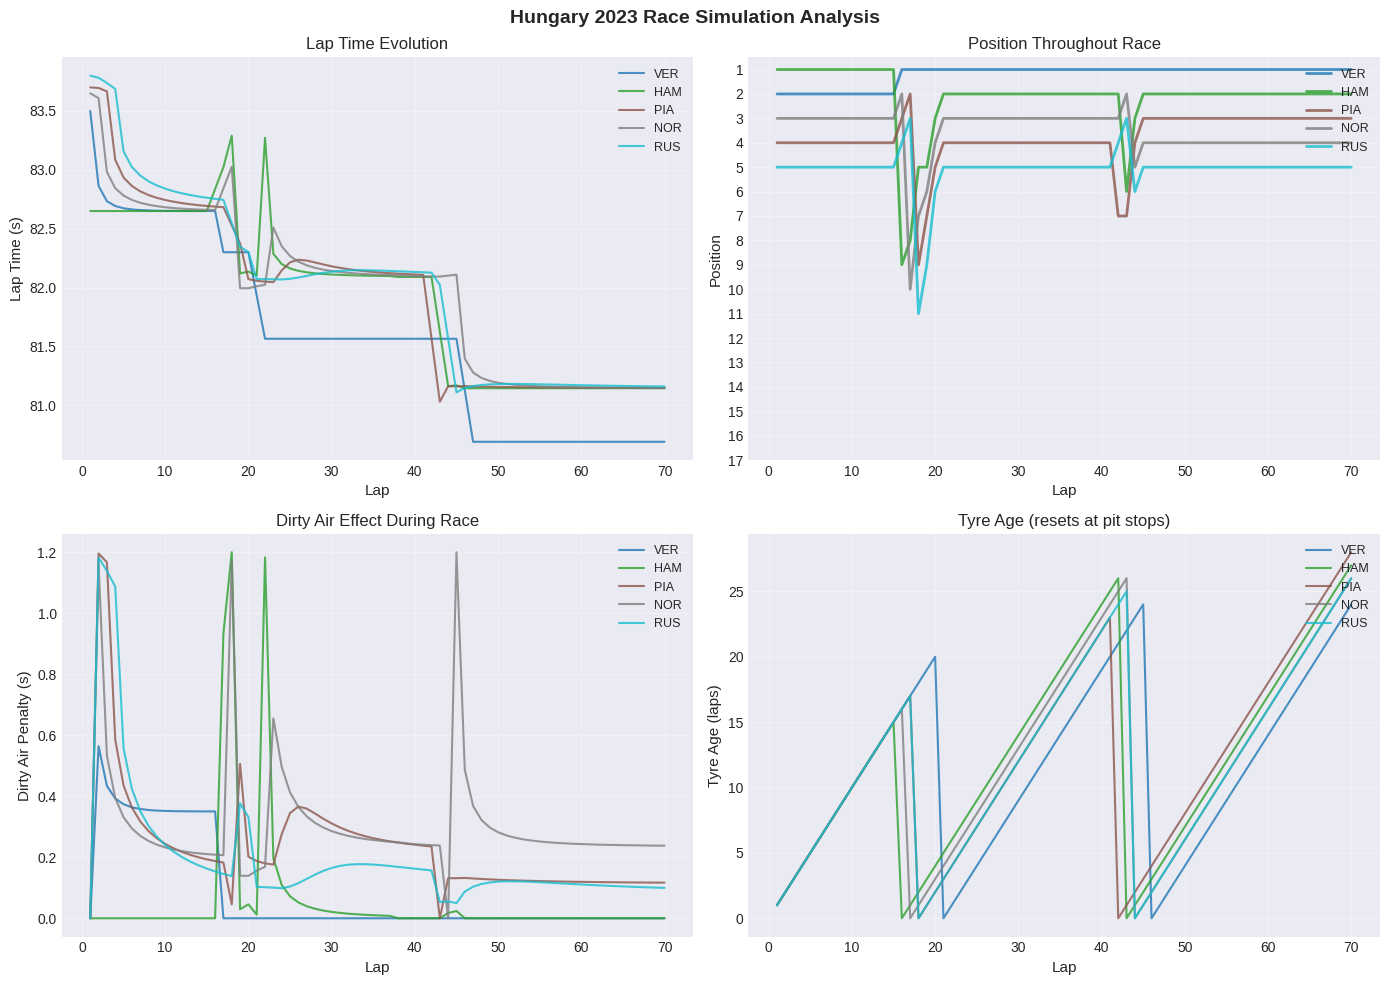

In [ ]:
# Create race visualizations

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Hungary 2023 Race Simulation Analysis', fontsize=14, fontweight='bold')

# Get top finishers for cleaner plots
top_drivers = final_results['Driver'].head(5).tolist()
colors = plt.cm.tab10(np.linspace(0, 1, len(top_drivers)))
driver_colors = {driver: colors[i] for i, driver in enumerate(top_drivers)}

# === Plot 1: Lap Time Evolution
ax1 = axes[0, 0]

for driver in top_drivers:
    driver_data = race_data[(race_data['driver'] == driver) & (~race_data['is_pitting'])]
    ax1.plot(driver_data['lap'], driver_data['lap_time'],
             label=driver, color=driver_colors[driver], alpha=0.8, linewidth=1.5)

ax1.set_xlabel('Lap', fontsize=11)
ax1.set_ylabel('Lap Time (s)', fontsize=11)
ax1.set_title('Lap Time Evolution', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

#Plot 2: Position Throughout Race
ax2 = axes[0, 1]

for driver in top_drivers:
    driver_data = race_data[race_data['driver'] == driver]
    ax2.plot(driver_data['lap'], driver_data['position'],
             label=driver, color=driver_colors[driver], alpha=0.8, linewidth=2)

ax2.set_xlabel('Lap', fontsize=11)
ax2.set_ylabel('Position', fontsize=11)
ax2.set_title('Position Throughout Race', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.invert_yaxis()  # P1 at top
ax2.set_yticks(range(1, len(hungary_2023_grid) + 1))
ax2.grid(True, alpha=0.3)

#Plot 3: Dirty Air Penalty Over Race
ax3 = axes[1, 0]

for driver in top_drivers:
    driver_data = race_data[race_data['driver'] == driver]
    ax3.plot(driver_data['lap'], driver_data['dirty_air_penalty'],
             label=driver, color=driver_colors[driver], alpha=0.8, linewidth=1.5)

ax3.set_xlabel('Lap', fontsize=11)
ax3.set_ylabel('Dirty Air Penalty (s)', fontsize=11)
ax3.set_title('Dirty Air Effect During Race', fontsize=12)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

#Plot 4: Tyre Age Evolution
ax4 = axes[1, 1]

for driver in top_drivers:
    driver_data = race_data[race_data['driver'] == driver]
    ax4.plot(driver_data['lap'], driver_data['Tyre_age'],
             label=driver, color=driver_colors[driver], alpha=0.8, linewidth=1.5)

ax4.set_xlabel('Lap', fontsize=11)
ax4.set_ylabel('Tyre Age (laps)', fontsize=11)
ax4.set_title('Tyre Age (resets at pit stops)', fontsize=12)
ax4.legend(loc='upper right', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Gap Analysis

Understanding race dynamics through:
1. **Gap to Leader** — How far behind the winner
2. **Gap to Car Ahead** — Dirty air exposure indicator

These gaps explain why certain drivers could overtake while others couldn't.

/tmp/ipython-input-2640312619.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  leader_by_lap = race_data.groupby('lap').apply(


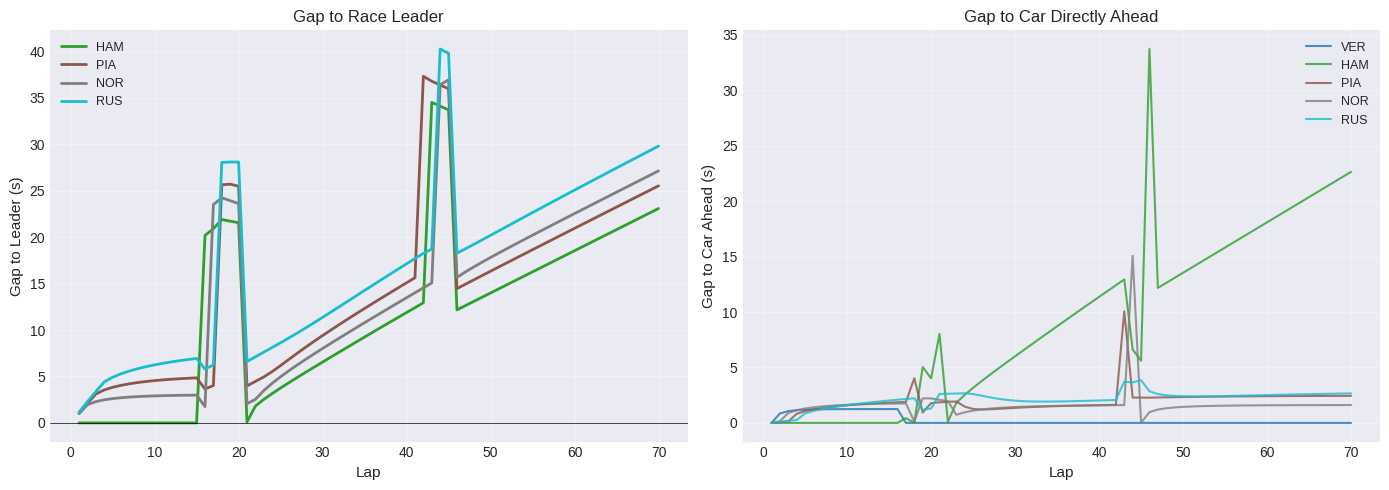

In [ ]:
# Gap to leader analysis

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Plot 1: Gap to Leader Over Race
ax1 = axes[0]

# Get leader's time at each lap
leader_by_lap = race_data.groupby('lap').apply(
    lambda x: x.loc[x['total_time'].idxmin(), 'total_time']
)

for driver in top_drivers[1:]:
    driver_data = race_data[race_data['driver'] == driver].set_index('lap')
    gap_to_leader = driver_data['total_time'] - leader_by_lap
    ax1.plot(gap_to_leader.index, gap_to_leader.values,
             label=driver, color=driver_colors[driver], linewidth=2)

ax1.set_xlabel('Lap', fontsize=11)
ax1.set_ylabel('Gap to Leader (s)', fontsize=11)
ax1.set_title('Gap to Race Leader', fontsize=12)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

#Plot 2: Gap to Car Ahead
ax2 = axes[1]

for driver in top_drivers:
    driver_data = race_data[race_data['driver'] == driver]

    gaps = driver_data['gap_ahead'].fillna(0)
    ax2.plot(driver_data['lap'], gaps,
             label=driver, color=driver_colors[driver], alpha=0.8, linewidth=1.5)

ax2.set_xlabel('Lap', fontsize=11)
ax2.set_ylabel('Gap to Car Ahead (s)', fontsize=11)
ax2.set_title('Gap to Car Directly Ahead', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary: Notebook 02

### What Was Built
- `RaceSimulator` class for multi-car simulation
- Dirty air model with inverse-square decay
- Position tracking based on cumulative time
- Pit stop handling with compound changes

### Key Findings
- Dirty air penalty is severe at Hungary (high downforce)
- Track position matters more than pure pace
- Cars in traffic accumulate significant time loss
- Pit stop timing affects track position, not just race time

### Simulation Limitations
- No undercut/overcut dynamics
- No Safety Car modeling
- No tyre degradation variance
- Deterministic (no stochastic or Monte Carlo yet)

### Next Steps
**Notebook 03** focuses on:
- Compound-specific tyre models
- Strategy optimization (optimal pit windows)
- Comparing 1-stop vs 2-stop strategies

---

